In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score

%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/toxicity/tfjs/default/1/group1-shard3of7
/kaggle/input/toxicity/tfjs/default/1/group1-shard2of7
/kaggle/input/toxicity/tfjs/default/1/group1-shard1of7
/kaggle/input/toxicity/tfjs/default/1/group1-shard4of7
/kaggle/input/toxicity/tfjs/default/1/model.json
/kaggle/input/toxicity/tfjs/default/1/group1-shard5of7
/kaggle/input/toxicity/tfjs/default/1/group1-shard6of7
/kaggle/input/toxicity/tfjs/default/1/group1-shard7of7
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Reading Test and Training Data

In [2]:
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv', encoding='latin-1')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
train.dropna(how = 'any', inplace = True, axis = 1)
train = train.drop('id', axis = 1)

In [3]:
train.tail(5)

,text,target
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1
7612,The Latest: More Homes Razed by Northern Calif...,1


In [4]:
print('There are {} rows and {} columns in train'.format(train.shape[0],train.shape[1]))
print('There are {} rows and {} columns in test'.format(test.shape[0],test.shape[1]))

There are 7613 rows and 2 columns in train
There are 3263 rows and 4 columns in test


In [5]:
train.groupby('target').describe()

text                                                               
       count unique                                                top freq
target                                                                     
0       4342   4315  The Prophet (peace be upon him) said 'Save you...    4
1       3271   3206  11-Year-Old Boy Charged With Manslaughter of T...   10

In [6]:
train['text_len'] = train['text'].apply(len)
train.tail()

,text,target,text_len
7608,Two giant cranes holding a bridge collapse int...,1,83
7609,@aria_ahrary @TheTawniest The out of control w...,1,125
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7611,Police investigating after an e-bike collided ...,1,137
7612,The Latest: More Homes Razed by Northern Calif...,1,94


Text(0.5, 0, 'text length')

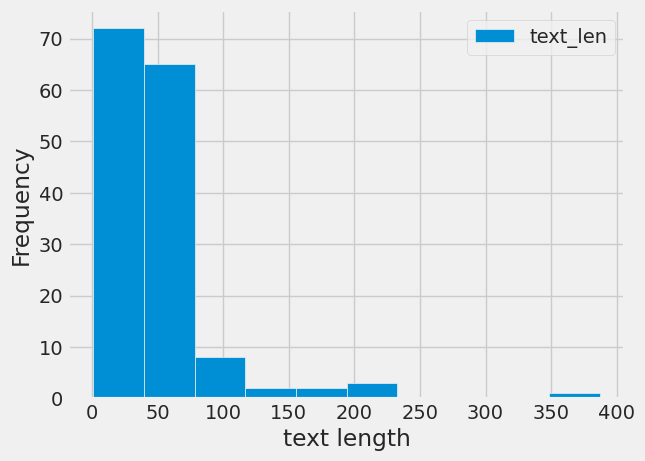

In [7]:
train['text_len'].value_counts().plot(kind='hist')
plt.legend()
plt.xlabel('text length')

### We can see most of the tweets are having tweets with length less 75 characters

## text_pre_processing

In [8]:
import string
from nltk.corpus import stopwords

def clean_text(text):
    '''Make text lowercase,,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower() ## convert to lower case
    text = re.sub('\[.*?\]', '', text) ## remove text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text) ## remove links
    text = re.sub('<.*?>+', '', text) 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) ##remove punctuation
    text = re.sub('\n', '', text) ## remove newlines
    text = re.sub('\w*\d\w*', '', text) ## removes any alphanumeric sequence that contains at least one digit from the text string.
    return text

In [9]:
train['clean_text'] = train['text'].apply(clean_text)

train.tail()

,text,target,text_len,clean_text
7608,Two giant cranes holding a bridge collapse int...,1,83,two giant cranes holding a bridge collapse int...
7609,@aria_ahrary @TheTawniest The out of control w...,1,125,ariaahrary thetawniest the out of control wild...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,s of volcano hawaii
7611,Police investigating after an e-bike collided ...,1,137,police investigating after an ebike collided w...
7612,The Latest: More Homes Razed by Northern Calif...,1,94,the latest more homes razed by northern califo...


## Dealing with Stopwords

In [10]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    words = text.split(' ')
    words = [word for word in words if word not in stop_words]
    text = ' '.join(words)
    return text


train['clean_text'] = train['clean_text'].apply(remove_stopwords)
train.tail()

,text,target,text_len,clean_text
7608,Two giant cranes holding a bridge collapse int...,1,83,two giant cranes holding bridge collapse nearb...
7609,@aria_ahrary @TheTawniest The out of control w...,1,125,ariaahrary thetawniest control wild fires cali...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,volcano hawaii
7611,Police investigating after an e-bike collided ...,1,137,police investigating ebike collided car little...
7612,The Latest: More Homes Razed by Northern Calif...,1,94,latest homes razed northern california wildfir...


In [11]:
import nltk
from nltk.stem import PorterStemmer


stemmer = nltk.SnowballStemmer("english")

def stemm_text(text):
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text
train['clean_text'] = train['clean_text'].apply(stemm_text)
train['clean_text'].loc[5433]

'polic kill hatchetwield gunman open fire insid nashvill movi theater aã¥ã\x8amiddleag manã¥ã\x8aarm wi '

In [12]:
porter_stemmer = nltk.PorterStemmer()

def stemm_text(text):
    text = ' '.join(porter_stemmer.stem(word) for word in text.split(' '))
    return text
train['clean_text'] = train['clean_text'].apply(stemm_text)
train['clean_text'].loc[5433]

'polic kill hatchetwield gunman open fire insid nashvil movi theater aã¥ã\x8amiddleag manã¥ã\x8aarm wi '

## Merging all the above functions together

In [13]:
def preprocess_data(text):
    # Clean puntuation, urls, and so on
    text = clean_text(text)
    # Remove stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Stemm all the words in the sentence
    text = ' '.join(porter_stemmer.stem(word) for word in text.split(' '))
    
    return text

In [14]:
train['clean_text'] = train['clean_text'].apply(preprocess_data)
train.head()

,text,target,text_len,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,69,deed reason earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,1,38,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,1,133,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",1,65,peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,1,88,got sent photo rubi alaska smoke wildfir pour ...


In [15]:
test.tail(7)

,id,keyword,location,text
3256,10857,NaN,NaN,To conference attendees! The blue line from th...
3257,10858,NaN,NaN,The death toll in a #IS-suicide car bombing on...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...


In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')
X_train = vectorizer.fit_transform(train['clean_text'])
y_train = train['target']
X_test = vectorizer.transform(test['text'])

In [17]:
print(X_test)

  (0, 1380)	0.683295083808629
  (0, 935)	0.7301423343725241
  (1, 5884)	0.5494893766848795
  (1, 5329)	0.6357870875604549
  (1, 2820)	0.5420666049498504
  (2, 5945)	0.43441313167070333
  (2, 5823)	0.4483502693002583
  (2, 5386)	0.38381857623938154
  (2, 4759)	0.5590112809706804
  (2, 2432)	0.3878878128164523
  (4, 6464)	0.45288200781725113
  (4, 6463)	0.4308950881437664
  (4, 6095)	0.48134049017291713
  (4, 5756)	0.4473306046756262
  (4, 1074)	0.42122912132190654
  (6, 6975)	0.806931324070396
  (6, 3571)	0.5906452727602223
  (7, 2861)	1.0
  (8, 4261)	0.6673113266284694
  (8, 2775)	0.7447788889014995
  (9, 2495)	1.0
  (10, 3588)	0.47425078814099125
  (10, 1181)	0.8803897943227469
  (12, 6141)	1.0
  (15, 4244)	0.22168698338141812
  :	:
  (3256, 3611)	0.4050357218030055
  (3256, 2990)	0.4926571390739094
  (3256, 676)	0.4249331095893369
  (3256, 143)	0.398967376798645
  (3257, 6261)	0.4881020371689813
  (3257, 1922)	0.5311554262945011
  (3257, 1537)	0.5172953307548783
  (3257, 1533)	0.3241

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [20]:
model = LogisticRegression(random_state = 42)
model.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [21]:
y_pred = model.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'acc:{acc}')

acc:0.7931713722915299


## Accuracy increased by 1% after using PorterStemmer

In [22]:
#Predictions on test set
y_pred_test = model.predict(X_test)
submission = pd.DataFrame({'id': test['id'], 'target': y_pred_test})
submission.to_csv('submission.csv', index=False)

## Support Vector Classifier -  giving the Accuracy of 79.71%

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [24]:
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [25]:
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'acc:{acc}')

acc:0.7931713722915299


In [26]:
#Predictions on test set
y_pred_test = clf.predict(X_test)
submission = pd.DataFrame({'id': test['id'], 'target': y_pred_test})
submission.to_csv('submission_svc.csv', index=False)

## XGboost -  Accuracy of 78.26%

In [27]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_clf = xgb.XGBClassifier(learning_rate=1)
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f'acc:{acc}')

acc:0.7688772160210111


In [28]:
y_pred

array([0, 0, 0, ..., 1, 1, 0])

## Hence we can compare and see that Support Vector Classifier works best for the given Dataset.